# Plot results using the DataFrame stored in pickle file

In [19]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import glob,imp,os,shutil
from pandas.io.json import json_normalize
import pyslha
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from collections import OrderedDict
import seaborn as sns

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options

#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

In [2]:
#Merge with SModelS DataFrame
dataDF = pd.read_pickle('EWino_scanRandom.pcl')
# print(dataDF.columns.values.tolist()) #Print all columns names

#### Set r = 0 for points with no results 

In [3]:
#Set points without results with r == 0
dataDF.fillna(value={'ExptRes.result0.r' : 0.0},inplace=True)
#Sort points according to r value:
dataDF = dataDF.sort_values(by=['ExptRes.result0.r'],ascending=False)
#Add simple flag for excluded points:
dataDF['excluded'] = dataDF['ExptRes.result0.r'] > 1.0 #Include flat k-factor

#### Add c*tau column for charginos

In [4]:
dataDF['ctau.1000024'] = 1.967e-16/dataDF['width.1000024']

### Get points excluded:

In [5]:
excluded = dataDF[dataDF['excluded'] == True]
allowed = dataDF[dataDF['excluded'] == False]
print('Total number of points = %i' %len(dataDF))
print('Total excluded = %i'%(len(excluded)))
print('Total allowed = %i'%(len(allowed)))

Total number of points = 47692
Total excluded = 3389
Total allowed = 44303


### Create analysis label for excluded points

In [6]:
anas = excluded['ExptRes.result0.AnalysisID'].value_counts()
anas.sort_values(inplace=True,ascending=False)
labels = []
for index, row in excluded.iterrows():
    ana = row['ExptRes.result0.AnalysisID']
    txList = sorted(row['ExptRes.result0.TxNames'])
    label = ana + ' (' + ','.join(txList) + ')'
    labels.append(label)
excluded['label'] = labels

In [7]:
print(excluded['label'].unique())

['ATLAS-SUSY-2016-06 (TDTM1F,TDTM2F)' 'CMS-SUS-17-004 (TChiWZoff)'
 'CMS-SUS-17-004 (TChiWZ)' 'ATLAS-SUSY-2016-24 (TChiWZ)'
 'ATLAS-SUSY-2019-08 (TChiWH)' 'ATLAS-SUSY-2018-32 (TChiWW)'
 'CMS-SUS-13-006 (TChiWZoff)']


### Get relevant official exclusion curves

In [8]:
excCurves = {}
excATLAS = np.genfromtxt('../EWino/data/HEPData-ins1641262-v4-Exclusion_contour_EW_2_obs_conv.txt',
                       names=True)

excCurves['ATLAS-SUSY-2016-06 (TDTM1F,TDTM2F)'] = np.array(list(zip(excATLAS['mC1_GeV'],1.967e-16/excATLAS['width_GeV'])))


excCurves['CMS-SUS-17-004 (TChiWZ)'] =  np.genfromtxt('../EWino/data/CMS_SUS_17_004_TChiWZ_obs.csv', 
                                                      delimiter=',')
excCurves['ATLAS-SUSY-2016-24 (TChiWZ)'] = np.genfromtxt('../EWino/data/HEPData-ins1658902-v1-Table_20.csv',
                       delimiter=',', skip_header=9)
excCurves['ATLAS-SUSY-2019-08 (TChiWH)'] = np.genfromtxt('../EWino/data/HEPData-ins1755298-v1-Observed_limit_1lbb.csv',
                       delimiter=',', skip_header=11)
excCurves['ATLAS-SUSY-2018-32 (TChiWW)'] = np.genfromtxt('../EWino/data/HEPData-ins1750597-v1-Exclusion_contour_(obs)_1.csv',
                       delimiter=',', skip_header=10)
excCurves['CMS-SUS-13-006 (TChiWZoff)'] = np.genfromtxt('../EWino/data/CMS_SUS_13_006_TChiWZ_obs.csv', 
                                                      delimiter=',')

#### Plot distribution excluded points

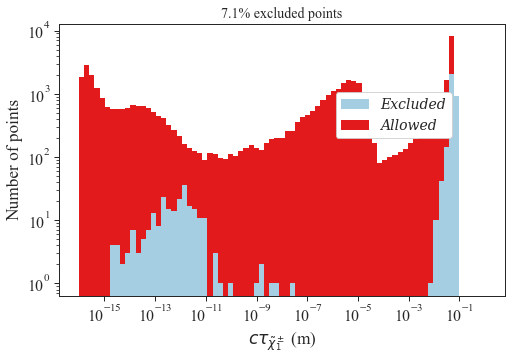

In [9]:
plt.figure(figsize=(8,5))
xExcluded = excluded['ctau.1000024']
xAllowed = allowed['ctau.1000024']
nbins = np.logspace(-16,0,80)
colors = np.take(sns.color_palette("Paired"),[0,5],axis=0)
plt.hist([xExcluded,xAllowed],nbins,stacked=True, 
                            histtype='barstacked', label=['Excluded','Allowed'],
                            linewidth=0, fill=True, color=colors)
lgd = plt.legend(bbox_to_anchor=(0.62, 0.75), loc=2, borderaxespad=0.,
                 prop={'family' :'serif','style' : 'italic', 'size' : 14},framealpha=1.)
plt.yscale('log')
plt.xscale('log')
plt.title('%1.1f%% excluded points' %(100*len(excluded)/float(len(dataDF))), fontsize=14)
plt.xlabel(r'$c \tau_{\tilde{\chi}_1^\pm}$ (m)')
plt.ylabel('Number of points')
plt.show()

### Plot excluded points grouped by most excluding analysis

ATLAS-SUSY-2016-06 (TDTM1F,TDTM2F)    3158
ATLAS-SUSY-2019-08 (TChiWH)            189
CMS-SUS-17-004 (TChiWZ)                 20
ATLAS-SUSY-2018-32 (TChiWW)             11
CMS-SUS-17-004 (TChiWZoff)               9
ATLAS-SUSY-2016-24 (TChiWZ)              1
CMS-SUS-13-006 (TChiWZoff)               1
Name: label, dtype: int64


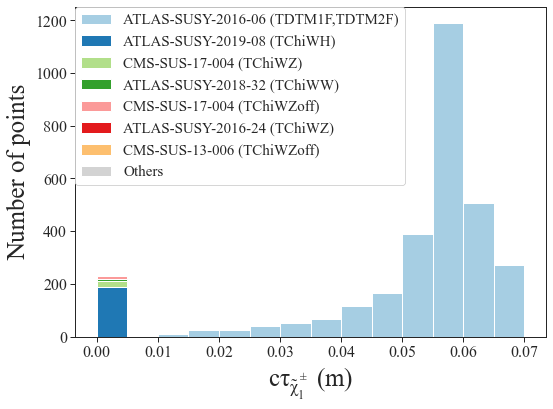

In [10]:
anas = excluded['label'].value_counts()
anas.sort_values(inplace=True,ascending=False)
print(anas)

plt.figure(figsize=(8,6))

# nbins = np.logspace(-3,3,20)
nbins=np.linspace(0,0.07,15)
colorDict = dict(zip(anas.index,sns.color_palette("Paired",len(anas))))
c_other = 'lightgray'
first = True
labels= []
hists = []
colors = []
xothers = []
for i,ana in enumerate(anas.index):
    x = excluded[excluded['label'] == ana]['ctau.1000024']
    if anas[ana] < 0:
        xothers += x.tolist()        
        continue
    else:
        color = colorDict[ana]
        label = ana
    
    hists.append(x)
    colors.append(color)
    labels.append(label)

hists.append(xothers)
labels.append('Others')
colors.append(c_other)
plt.hist(hists,nbins,color=colors,label=labels,
                            histtype='barstacked',
                            linewidth=1, fill=True)

lgd = plt.legend(loc='upper left', borderaxespad=0.,framealpha=1.,fontsize=15)

# plt.ylim(0,6500)
# plt.xlim(0,0.07)
# plt.title('SModelS v2.0', fontsize=26)
plt.xlabel(r'$\mathregular{c \tau_{\tilde{\chi}_1^\pm}}$ (m)',fontsize = 25)
plt.ylabel('Number of points',fontsize = 25)
plt.tight_layout()
plt.savefig('Wino_v2.png')
plt.show()

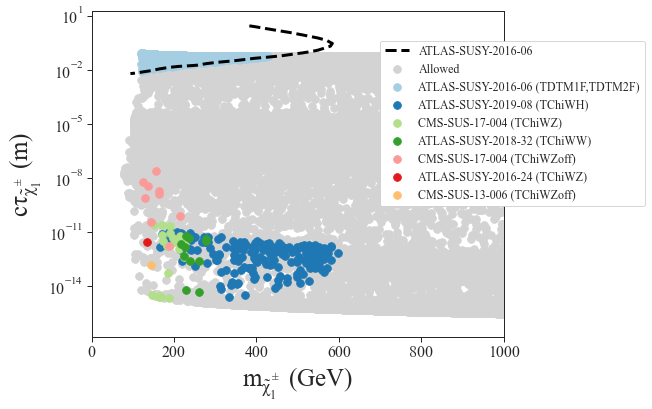

In [11]:
anas = excluded['label'].value_counts()
anas.sort_values(inplace=True,ascending=False)

plt.figure(figsize=(9,6))

# nbins = np.logspace(-3,3,20)
nbins=np.linspace(0,0.07,15)
colorDict = dict(zip(anas.index,sns.color_palette("Paired",len(anas))))
c_other = 'lightgray'


x = allowed['mass.1000024']
y = allowed['ctau.1000024']
plt.scatter(x,y,color=c_other,label='Allowed',s=60)

for i,ana in enumerate(anas.index):
    x = excluded[excluded['label'] == ana]['mass.1000024']
    y = excluded[excluded['label'] == ana]['ctau.1000024']
    color = colorDict[ana]
    label = ana
    plt.scatter(x,y,color=color,label=label,s=60)

    
#Add official DT exclusion curve
offExc = excCurves['ATLAS-SUSY-2016-06 (TDTM1F,TDTM2F)']
c = colorDict['ATLAS-SUSY-2016-06 (TDTM1F,TDTM2F)']
plt.plot(offExc[:,0],offExc[:,1],label='ATLAS-SUSY-2016-06',linewidth=3,linestyle='--',color='black')

lgd = plt.legend(loc=(0.7,0.4), framealpha=1.,fontsize=12)
plt.yscale('log')
# plt.ylim(0,700)
plt.xlim(0,1000)
plt.xlabel(r'$\mathregular{m_{\tilde{\chi}_1^\pm}}$ (GeV)',fontsize = 25)
plt.ylabel(r'$\mathregular{c \tau_{\tilde{\chi}_1^\pm}}$ (m)',fontsize = 25)
plt.tight_layout()
plt.show()

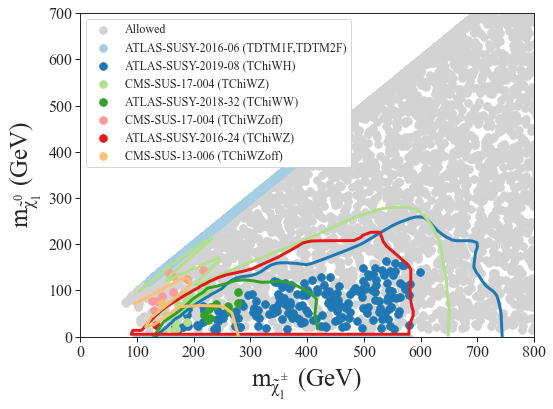

In [12]:
anas = excluded['label'].value_counts()
anas.sort_values(inplace=True,ascending=False)

plt.figure(figsize=(8,6))

colorDict = dict(zip(anas.index,sns.color_palette("Paired",len(anas))))
c_other = 'lightgray'


x = allowed['mass.1000024']
y = allowed['mass.1000022']
plt.scatter(x,y,color=c_other,label='Allowed',s=60)

for ana in anas.index:
    x = excluded[excluded['label'] == ana]['mass.1000024']
    y = excluded[excluded['label'] == ana]['mass.1000022']
    color = colorDict[ana]
    label = ana
    plt.scatter(x,y,color=color,label=label,s=60)

for ana in anas.index:
    if not ana in excCurves: continue
    curve = excCurves[ana]
    color = colorDict[ana]
    plt.plot(curve[:,0],curve[:,1],linewidth=3,linestyle='-',color=color)
        

lgd = plt.legend(loc='upper left', framealpha=1.,fontsize=12)

plt.ylim(0,700)
plt.xlim(0,800)
plt.xlabel(r'$\mathregular{m_{\tilde{\chi}_1^\pm}}$ (GeV)',fontsize = 25)
plt.ylabel(r'$\mathregular{m_{\tilde{\chi}_1^0}}$ (GeV)',fontsize = 25)
plt.tight_layout()
plt.show()

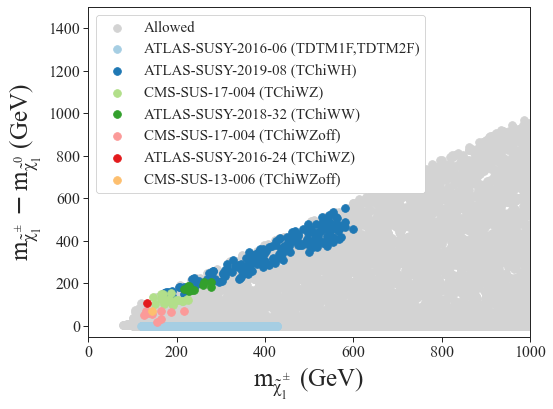

In [13]:
anas = excluded['label'].value_counts()
anas.sort_values(inplace=True,ascending=False)

plt.figure(figsize=(8,6))

colorDict = dict(zip(anas.index,sns.color_palette("Paired",len(anas))))
c_other = 'lightgray'


x = allowed['mass.1000024']
y = allowed['mass.1000022']
y = x-y
plt.scatter(x,y,color=c_other,label='Allowed',s=60)
for i,ana in enumerate(anas.index):
    x = excluded[excluded['label'] == ana]['mass.1000024']
    y = excluded[excluded['label'] == ana]['mass.1000022']
    y = x-y
    color = colorDict[ana]
    label = ana
    plt.scatter(x,y,color=color,label=label,s=60)


lgd = plt.legend(loc='upper left', framealpha=1.,fontsize=15)

plt.ylim(-50,1500)
plt.xlim(0,1000)

plt.ylabel(r'$\mathregular{m_{\tilde{\chi}_1^\pm}}-\mathregular{m_{\tilde{\chi}_1^0}}$ (GeV)',fontsize = 25)
plt.xlabel(r'$\mathregular{m_{\tilde{\chi}_1^\pm}}$ (GeV)',fontsize = 25)
plt.tight_layout()
plt.show()

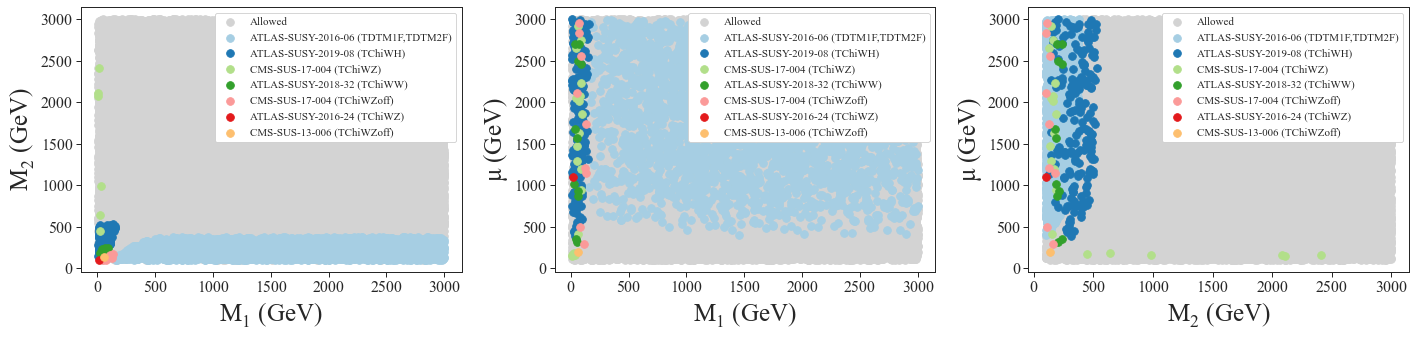

In [14]:
anas = excluded['label'].value_counts()
anas.sort_values(inplace=True,ascending=False)

colorDict = dict(zip(anas.index,sns.color_palette("Paired",len(anas))))
c_other = 'lightgray'


fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(20,5))
axislabels = {'extpar.1' : r'$\mathregular{M_1}$ (GeV)',
              'extpar.2' : r'$\mathregular{M_2}$ (GeV)',
              'extpar.23' : r'$\mathregular{\mu}$ (GeV)'}
i = 0
for ix,xvar in enumerate(axislabels):
    for iy,yvar in enumerate(axislabels):
        if iy <= ix: continue
        ax = axes[i]
        x = allowed[xvar]
        y = allowed[yvar]
        ax.scatter(x,y,color=c_other,label='Allowed',s=60)
        for ana in anas.index:
            x = excluded[excluded['label'] == ana][xvar]
            y = excluded[excluded['label'] == ana][yvar]
            color = colorDict[ana]
            label = ana
            ax.scatter(x,y,color=color,label=label,s=60)
        ax.set_ylabel(axislabels[yvar],fontsize = 25)
        ax.set_xlabel(axislabels[xvar],fontsize = 25)
        i += 1     
        lgd = ax.legend(loc='upper right', framealpha=1.,fontsize=11)




plt.tight_layout()
plt.show()



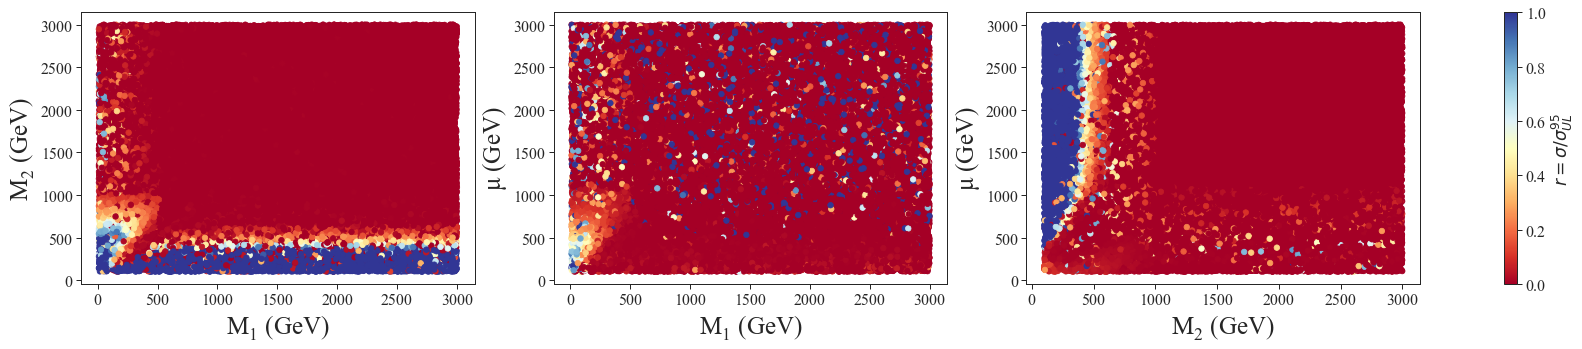

In [15]:
cm = plt.cm.get_cmap('RdYlBu')
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(30,5))
axislabels = {'extpar.1' : r'$\mathregular{M_1}$ (GeV)',
              'extpar.2' : r'$\mathregular{M_2}$ (GeV)',
              'extpar.23' : r'$\mathregular{\mu}$ (GeV)'}
i = 0
for ix,xvar in enumerate(axislabels):
    for iy,yvar in enumerate(axislabels):
        if iy <= ix: continue
        ax = axes[i]
        x = dataDF[xvar]
        y = dataDF[yvar]
        z = dataDF['ExptRes.result0.r']
        x = x[z.argsort()]
        y = y[z.argsort()]
        z = z[z.argsort()]        
        a = ax.scatter(x,y,c=z,s=30,vmin=0,vmax=1,cmap=cm)
        ax.set_ylabel(axislabels[yvar],fontsize = 25)
        ax.set_xlabel(axislabels[xvar],fontsize = 25)
        i += 1     

cb = fig.colorbar(a, ax=axes.ravel().tolist())
cb.set_label(r'$r = \sigma/\sigma_{UL}^{95}$')


plt.show()

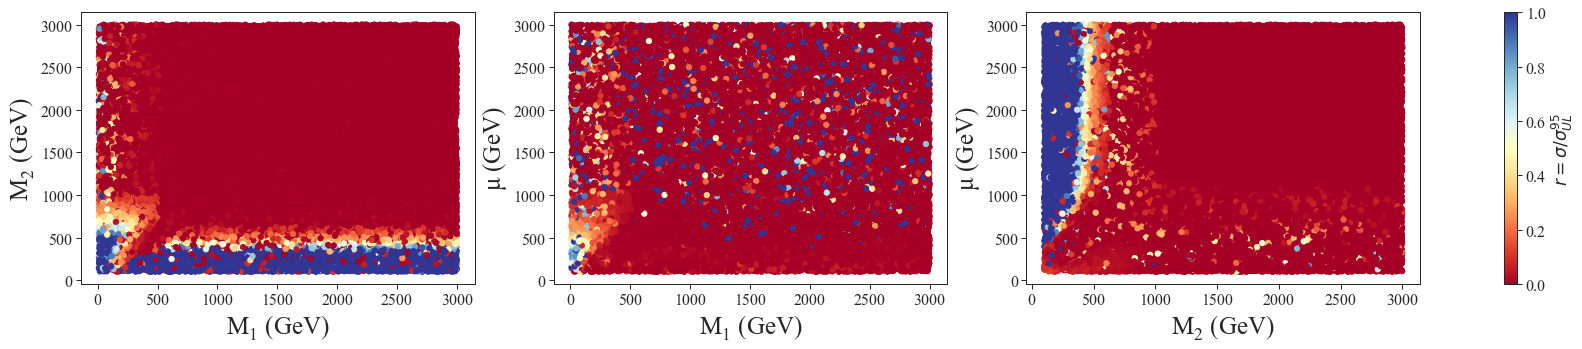

In [16]:
cm = plt.cm.get_cmap('RdYlBu')
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(30,5))
axislabels = {'extpar.1' : r'$\mathregular{M_1}$ (GeV)',
              'extpar.2' : r'$\mathregular{M_2}$ (GeV)',
              'extpar.23' : r'$\mathregular{\mu}$ (GeV)'}
i = 0
for ix,xvar in enumerate(axislabels):
    for iy,yvar in enumerate(axislabels):
        if iy <= ix: continue
        ax = axes[i]
        x = dataDF[xvar]
        y = dataDF[yvar]
        z = dataDF['ExptRes.result0.r']
        x = x[(-z).argsort()]
        y = y[(-z).argsort()]
        z = z[(-z).argsort()]        
        a = ax.scatter(x,y,c=z,s=30,vmin=0,vmax=1,cmap=cm)
        ax.set_ylabel(axislabels[yvar],fontsize = 25)
        ax.set_xlabel(axislabels[xvar],fontsize = 25)
        i += 1     

cb = fig.colorbar(a, ax=axes.ravel().tolist())
cb.set_label(r'$r = \sigma/\sigma_{UL}^{95}$')


plt.show()

In [20]:
# #Count points with 0.5 <= r < 1
# border = dataDF[(dataDF['ExptRes.result0.r'] > 0.5) & (dataDF['ExptRes.result0.r'] < 1.0)]
# print('%i files found' %len(border))
# #Copy files to ../EWino/data/slha_scanRandom_border
# for f in border['filename']:
#     f_old = os.path.join('../EWino/data/slha_scanRandom/',f)
#     f_new = os.path.join('../EWino/data/slha_scanRandom_border/',f)
#     shutil.copyfile(f_old,f_new)

1150 files found
